In [5]:
import os
import glob
from typing import Dict
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from py_utils import data_ops
from lib import misc

import main_fte

plt.style.use(os.path.join("../configs", "mechatronics_style.yaml"))
mechatronics_orange = '#FF6400'
mechatronics_charcoal = '#5A5A5A'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# First load all labelled frames into a pandas dataframe.
gt_root_dir = "/Users/zico/msc/data/gt_labels"
labelled_files = sorted(glob.glob(os.path.join(gt_root_dir, "**/CollectedData_UCT.h5"), recursive=True))
vid = None
for curr_file in labelled_files:
    vid = curr_file.split(gt_root_dir + "/")[1]
    vid = vid.split("/")[0]
    # Assuming that cam1 indicates the start of a new video sequence (the videos are sorted above).
    cam_idx = int(vid[-1])
    if cam_idx == 1:
        out_dir = curr_file.split("cam1/CollectedData_UCT.h5")[0]
        os.makedirs(out_dir, exist_ok=True)
    try:
        curr_df = pd.read_hdf(curr_file)
    except ValueError:
        continue    
    start_frame = int(curr_df.index[0].split("img")[1][0:3])
    frame_index = range(start_frame, start_frame + len(curr_df.index))
    curr_df.index = frame_index
    curr_df.to_hdf(os.path.join(out_dir, f"cam{cam_idx}.h5"), "df_with_missing", format="table", mode="w")

In [ ]:
def load_dlc_points_as_df(df_fpaths):
    dfs = []
    cam_indices = []
    for path in df_fpaths:
        vid = path.split(".h5")[0]
        cam_indices.append(int(vid[-1]) - 1)
        dlc_df = pd.read_hdf(path)
        dlc_df = dlc_df.droplevel([0], axis=1).swaplevel(0,1,axis=1).T.unstack().T.reset_index().rename({'level_0':'frame'}, axis=1)
        dlc_df.columns.name = ''
        dfs.append(dlc_df)
    #create new dataframe
    dlc_df = pd.DataFrame(columns=['frame', 'camera', 'marker', 'x', 'y'])
    for i, df in enumerate(dfs):
        df['camera'] = cam_indices[i]
        df.rename(columns={'bodyparts':'marker'}, inplace=True)
        dlc_df = pd.concat([dlc_df, df], sort=True, ignore_index=True)

    dlc_df = dlc_df[['frame', 'camera', 'marker', 'x', 'y']]
    return dlc_df

In [ ]:
dlc_dirs = ("/Users/zico/msc/data/gt_labels/2019_03_09LilyFlick", "/Users/zico/msc/data/gt_labels/2019_03_09JulesFlick2", "/Users/zico/msc/data/gt_labels/2017_12_16PhantomFlick2_1", "/Users/zico/msc/data/gt_labels/2017_09_03ZorroFlick1_1")
for dlc_file in dlc_dirs:
    dlc_fpaths = sorted(glob.glob(os.path.join(dlc_file, "*.h5")))
    res_df = load_dlc_points_as_df(dlc_fpaths)
    df = pd.DataFrame(res_df)
    ret_name = dlc_file.split("/")[-1]
    print(f"Saving...{ret_name}")
    df.to_csv(os.path.join(dlc_file, f"{ret_name}.csv"))

In [ ]:
root_results_dir = "/Users/zico/msc/data/PairwiseExperimentResults4"
burst_lengths = (1, 5, 10, 15, 20)
num_drop_outs = (0, 25, 50, 75, 90)
drop_out_range = (65, 155)

# Generate dataset of the manually dropped measurements.
drop_out_dataset = {}
for burst in burst_lengths:
    for num_filtered in num_drop_outs:
        drop_out_frames = []
        if num_filtered == 0 or num_filtered == 90:
            continue
        elif burst == 1:
             # Randomly select unique frames to drop out.
            drop_out_frames = random.sample(range(*drop_out_range), num_filtered)
        else:
            # Manullay select uniform bursts.
            num_bursts = np.ceil(num_filtered / burst)
            burst_gaps = np.ceil((drop_out_range[1] - drop_out_range[0]) / num_bursts)
            filtered_frames = np.asarray([range(i, i + burst) for i in range(*drop_out_range, int(burst_gaps))]).flatten()
            gen_diff = len(filtered_frames) - num_filtered
            drop_out_frames = filtered_frames[:-gen_diff] if gen_diff > 0 else filtered_frames

        print(f"({burst}, {num_filtered}): {len(drop_out_frames)}")
        assert len(drop_out_frames) == len(set(drop_out_frames)) and len(drop_out_frames) == num_filtered
        drop_out_dataset[(burst, num_filtered)] = drop_out_frames

drop_out_dataset[(1, 0)] = []
drop_out_dataset[(1, 90)] = list(range(*drop_out_range))
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in drop_out_dataset.items()]), columns=list(drop_out_dataset.keys()))
df.to_csv(os.path.join(root_results_dir, "manual_drop_outs.csv"))

In [ ]:
drop_out_dataset = pd.read_csv(os.path.join(root_results_dir, "manual_drop_outs.csv"))
tup = (1, 0)
drop_out_dataset[str(tup)].values

In [ ]:
root_dir = os.path.join("/Users/zico/OneDrive - University of Cape Town/CheetahReconstructionResults/cheetah_videos")
root_results_dir = "/Users/zico/msc/data/PairwiseExperimentResults3"
burst_lengths = (1, 5, 10, 15)
num_drop_outs = (0, 25, 50, 75, 90)
drop_out_range = (15, 105)
data_path = os.path.join("2017_08_29", "top", "jules", "run1_1")
start_frame = 10
end_frame = 110
dlc_thresh = 0.5

# tests = ("Normal", "Pairwise")
tests = ("Pairwise")
filtered_markers = ("r_front_ankle", "r_front_paw", "r_back_ankle", "r_back_paw")
drop_out_dataset = pd.read_csv(os.path.join(root_results_dir, "manual_drop_outs.csv"))
for test in tests:
    for burst in burst_lengths:
        for num_filtered in num_drop_outs:
            out_prefix = os.path.join(root_results_dir, test, f"{num_filtered}_percent_{burst}_burst")
            try:
                drop_out_frames = list(drop_out_dataset[str((burst, num_filtered))].values)
            except KeyError:
                continue
            print(f"Run test: {out_prefix}")
            # Run the optimisation
            main_fte.run(root_dir, data_path, start_frame, end_frame, dlc_thresh, filtered_markers = filtered_markers, drop_out_frames = drop_out_frames,  pairwise_included = 2 if test == "Pairwise" else 0, out_dir_prefix=out_prefix)
            # Produce results
            _, _ = main_fte.metrics(root_dir, data_path, start_frame, end_frame, dlc_thresh, out_dir_prefix=out_prefix)

Text(0.5, 0, 'Percentage of Measurements Dropped')

Text(0, 0.5, 'Error [px]')

Text(0.5, 0, 'Percentage of Measurements Dropped')

Text(0, 0.5, 'Error [px]')

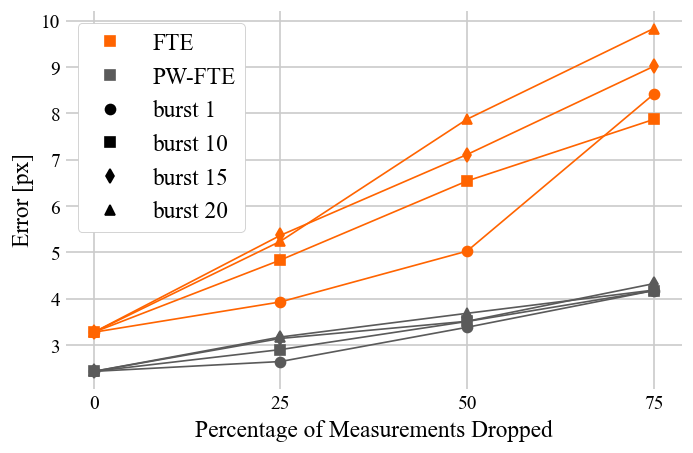

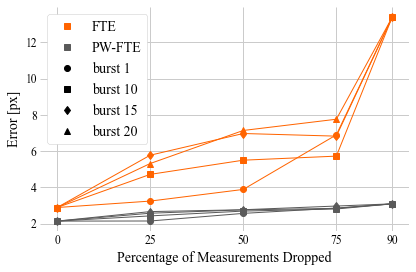

In [8]:
root_results_dir = "/Users/zico/msc/data/PairwiseVsNormalExperiment5"
# test_run_dir = "2017_08_29/top/jules/run1_1/fte_pw"
test_run_dir = "2019_03_09/jules/flick1/fte_pw"
normal_dir = os.path.join(root_results_dir, "Normal")
pw_dir = os.path.join(root_results_dir, "Pairwise")

# removed_markers = ("r_front_ankle", "r_front_paw", "r_back_ankle", "r_back_paw")
# removed_markers = ("l_front_ankle", "l_front_paw", "l_back_ankle", "l_back_paw", "r_front_ankle", "r_front_paw", "r_back_ankle", "r_back_paw")
removed_markers = ("r_front_ankle", "r_front_knee", "r_back_ankle", "r_back_knee")
burst_lengths = (1, 10, 15, 20)
num_drop_outs = (0, 25, 50, 75, 90)
drop_out_dataset = pd.read_csv(os.path.join(root_results_dir, "manual_drop_outs.csv"))
valid_tests = drop_out_dataset.columns.values
plots = {}
for burst in burst_lengths:
    plots[burst] = [[], []]
    for num_filtered in num_drop_outs:
        burst_ = burst
        if str((burst, num_filtered)) not in valid_tests:
            burst_ = 1
        for i, test_type in enumerate((normal_dir, pw_dir)):
            test_dir = os.path.join(test_type, f"{num_filtered}_percent_{burst_}_burst")
            meas = pd.read_csv(os.path.join(test_dir, test_run_dir, "measurement_results.csv"))
            errors = pd.read_csv(os.path.join(test_dir, test_run_dir, "reprojection_results.csv"))
            errors["# meas [%]"] = meas.iloc[0, 1:].values
            data = errors.rename(columns={ "Unnamed: 0": "marker"})
            data = data[["marker", "mean", "std", "# meas [%]"]]
            avg_limb_data = data.loc[data["marker"].isin(removed_markers)]
            avg_limb_data = avg_limb_data.mean()
            avg_data = data.mean()
            plots[burst][i].append([*avg_data.values, *avg_limb_data.values])

# fig = plt.figure(figsize=(12, 12), dpi=120)
# fig.suptitle("Average Reprojection Error")
# for i, burst_plot in enumerate(plots.keys()):
#     plotting_data = np.asarray(plots[burst_plot])
#     ax = fig.add_subplot(2, 2, i+1)
#     plot_data = ax.plot(num_drop_outs[:-1], plotting_data[0, :-1, 0], "b")
#     plot_data += ax.plot(num_drop_outs[:-1], plotting_data[1, :-1, 0], "g")
#     ax.set_xticks(num_drop_outs)
#     ax.set_title(f"Burst Length [frames]: {burst_plot}")

# fig.legend(plot_data, ("Normal", "Pairwise"), loc="upper right")
# fig.text(0.5, 0.007, "Percentage of Measurements Dropped", ha='center', va='center')
# fig.text(0.007, 0.5, "Error [px]", ha='center', va='center', rotation='vertical')
# fig.savefig(os.path.join(root_results_dir, "avg_error.pdf"))

burst_type_markers = ('o', 's', 'd', '^', '*')
colors = [mechatronics_orange, mechatronics_charcoal]
f = lambda m,c: ax.plot([],[],marker=m, color=c, ls="none")[0]

fig = plt.figure(dpi=120)
# fig.suptitle("Average Reprojection Error")
ax = fig.add_subplot(1, 1, 1)
for i, burst_plot in enumerate(plots.keys()):
    plotting_data = np.asarray(plots[burst_plot])
    # if burst_plot == 1:
    #     ax.plot(num_drop_outs, plotting_data[0, :, 0], color=mechatronics_orange, marker=burst_type_markers[i])
    #     ax.plot(num_drop_outs, plotting_data[1, :, 0], color=mechatronics_charcoal, marker=burst_type_markers[i])
    # else:
    ax.plot(num_drop_outs[:-1], plotting_data[0, :-1, 0], color=mechatronics_orange, marker=burst_type_markers[i])
    ax.plot(num_drop_outs[:-1], plotting_data[1, :-1, 0], color=mechatronics_charcoal, marker=burst_type_markers[i])
    ax.set_xticks(num_drop_outs)

handles = [f("s", colors[i]) for i in range(2)]
handles += [f(burst_type_markers[i], "k") for i in range(5)]
labels =  ["FTE", "PW-FTE", "burst 1", "burst 10", "burst 15", "burst 20"]

ax.legend(handles, labels, loc="upper left", framealpha=1)
ax.set_xlabel("Percentage of Measurements Dropped")
ax.set_ylabel("Error [px]")
fig.savefig(os.path.join(root_results_dir, "avg_error_all_sides.png"))

fig = plt.figure()
# fig.suptitle("Reprojection Standard Deviation")
ax = fig.add_subplot(1, 1, 1)
for i, burst_plot in enumerate(plots.keys()):
    plotting_data = np.asarray(plots[burst_plot])
    ax.plot(num_drop_outs, plotting_data[0, :, 1], color=mechatronics_orange, marker=burst_type_markers[i])
    ax.plot(num_drop_outs, plotting_data[1, :, 1], color=mechatronics_charcoal, marker=burst_type_markers[i])
    ax.set_xticks(num_drop_outs)

handles = [f("s", colors[i]) for i in range(2)]
handles += [f(burst_type_markers[i], "k") for i in range(5)]

ax.legend(handles, labels, loc="upper left", framealpha=1)
ax.set_xlabel("Percentage of Measurements Dropped")
ax.set_ylabel("Error [px]")
fig.savefig(os.path.join(root_results_dir, "removed_marker_std_error.png"))




(55.0, 160.0)

[Text(0, 0, 'Kept'), Text(0, 1, 'Dropped')]

(55.0, 160.0)

[Text(0, 0, 'Kept'), Text(0, 1, 'Dropped')]

Text(0.5, 0.04, 'Frame Number')

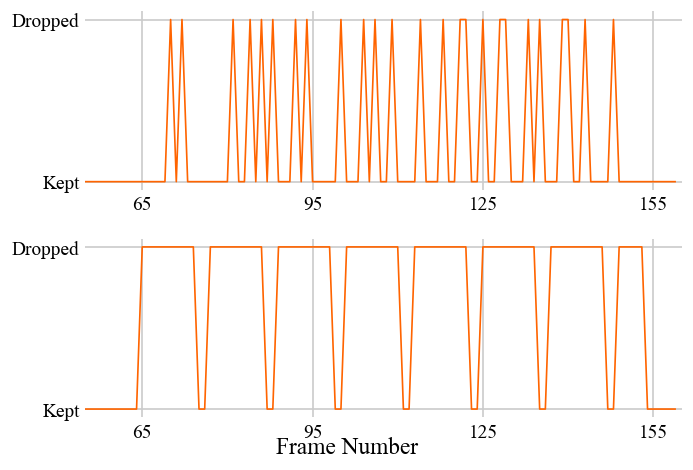

In [7]:

fig = plt.figure(dpi=120)
y1 = np.zeros((160, 1))
y2 = np.zeros((160, 1))
x_range = np.arange(59, 160)
x_ticks = (65, 95, 125, 155)
y1[drop_out_dataset["(1, 25)"].to_numpy(dtype=np.int16).flatten()] = 1.0
y2[drop_out_dataset["(10, 75)"].to_numpy(dtype=np.int16).flatten()] = 1.0

ax = fig.add_subplot(2, 1, 1)
ax.plot(y1, color=mechatronics_orange, label="Burst 1 at 25%")
ax.set_xticks(x_ticks)
ax.set_xlim(55, 160)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Kept", "Dropped"])
# ax.set_xlabel("Frame Number")

ax = fig.add_subplot(2, 1, 2)
ax.plot(y2, color=mechatronics_orange, label="Burst 10 at 75%")
ax.set_xticks(x_ticks)
ax.set_xlim(55, 160)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Kept", "Dropped"])
# ax.set_xlabel("Frame Number")
# ax.legend(loc="upper left", framealpha=1)

fig.text(0.5, 0.04, "Frame Number", ha='center', va='center')
fig.savefig(os.path.join(root_results_dir, "drop_outs.png"))

In [10]:
# Convert 2D ground truth to H5 from pickle format - so this can be used in the metric function in main_fte.
fname = "/Users/zico/Downloads/zorro_flick_gt/fte/2D_reprojected_GT"
p_data = data_ops.load_pickle(f"{fname}.pickle")
bodyparts =  ["nose", "r_eye", "l_eye", "neck_base", "spine",
 "tail_base", "tail1", "tail2",
 "r_shoulder", "r_front_knee", "r_front_ankle", "r_front_paw",
 "l_shoulder", "l_front_knee","l_front_ankle", "l_front_paw",
 "r_hip", "r_back_knee", "r_back_ankle", "r_back_paw",
 "l_hip", "l_back_knee", "l_back_ankle", "l_back_paw"]

start_frame = 59
gt_data = []
p_data.keys()
for (frame, cam) in p_data.keys():
    # if frame >= 70 and frame <= 79:
    d = list(zip(bodyparts, p_data[(frame, cam)]))
    d = [(frame + start_frame, cam - 1, b, *list(v)) for (b, v) in d]
    gt_data += d

df = pd.DataFrame(gt_data, columns=["frame", "camera", "marker", "x", "y"])
df.to_csv(f"{fname}.csv")

dict_keys([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (60, 1), (60, 2), (60, 3), (60, 4), (60, 5), (60, 6), (61, 1), (61, 2), (61, 3), (61, 4), (61, 5), (61, 6), (62, 1), (62, 2), (62, 3), (62, 4), (62, 5), (62, 6), (63, 1), (63, 2), (63, 3), (63, 4), (63, 5), (63, 6), (64, 1), (64, 2), (64, 3), (64, 4), (64, 5), (64, 6), (65, 1), (65, 2), (65, 3), (65, 4), (65, 5), (65, 6), (66, 1), (66, 2), (66, 3), (66, 4), (66, 5), (66, 6), (67, 1), (67, 2), (67, 3), (67, 4), (67, 5), (67, 6), (68, 1), (68, 2), (68, 3), (68, 4), (68, 5), (68, 6), (69, 1), (69, 2), (69, 3), (69, 4), (69, 5), (69, 6), (70, 1), (70, 2), (70, 3), (70, 4), (70, 5), (70, 6), (71, 1), (71, 2), (71, 3), (71, 4), (71, 5), (71, 6), (72, 1), (72, 2), (72, 3), (72, 4), (72, 5), (72, 6), (73, 1), (73, 2), (73, 3), (73, 4), (73, 5), (73, 6), (74, 1), (74, 2), (74, 3), (74, 4), (74, 5), (74, 6), (75, 1), (75, 2), (75, 3), (75, 4), (75, 5), (75, 6), (76, 1), (76, 2), (76, 3), (76, 4), (76, 5), (76, 6), (77, 1), (77, 2), (77, 

In [ ]:
# Convert 3D ground truth to H5 from pickle format - so this can be used in the metric function in main_fte.
p_data = data_ops.load_pickle("/Users/zico/Downloads/run/3D_GT.pickle")
bodyparts =  ["nose", "r_eye", "l_eye", "neck_base", "spine",
 "tail_base", "tail1", "tail2",
 "r_shoulder", "r_front_knee", "r_front_ankle", "r_front_paw",
 "l_shoulder", "l_front_knee","l_front_ankle", "l_front_paw",
 "r_hip", "r_back_knee", "r_back_ankle", "r_back_paw",
 "l_hip", "l_back_knee", "l_back_ankle", "l_back_paw"]

p_data = np.asarray(p_data)
start_frame = 60
end_frame = 160
frames = np.arange(start_frame, end_frame).reshape((-1, 1))
n_frames = len(frames)
points_3d = []

for i, m in enumerate(bodyparts):
    _pt3d = np.squeeze(p_data[:, i, :])
    marker_arr = np.array([m] * n_frames).reshape((-1, 1))
    _pt3d = np.hstack((frames, marker_arr, _pt3d))
    points_3d.append(_pt3d)

df = pd.DataFrame(np.vstack(points_3d), columns=["frame", "marker", "x", "y", "z"]).astype({
    "frame": "int64",
    "marker": "str",
    "x": "float64",
    "y": "float64",
    "z": "float64"
})
df.to_csv("/Users/zico/Downloads/run/3D_GT.csv")

In [ ]:
def residual_error_3d(points_3d_GT, points_3d, markers):
    error_dfs = []
    for m in markers:
        # extract frames
        q = f'marker == "{m}"'
        pts_3d = points_3d.query(q)
        gt_pts_3d = points_3d_GT.query(q)
        pts_3d = pts_3d[pts_3d[['x', 'y', 'z']].notnull().all(axis=1)]
        gt_pts_3d = gt_pts_3d[gt_pts_3d[['x', 'y', 'z']].notnull().all(axis=1)]
        valid_frames = np.intersect1d(gt_pts_3d['frame'].to_numpy(), pts_3d['frame'].to_numpy())
        gt_pts_3d = gt_pts_3d[gt_pts_3d['frame'].isin(valid_frames)].sort_values(by=['frame'])
        pts_3d = pts_3d[pts_3d['frame'].isin(valid_frames)].sort_values(by=['frame'])

        # get 2d and reprojected points
        frames = gt_pts_3d['frame'].to_numpy()
        gt_pts = gt_pts_3d[['x', 'y', 'z']].to_numpy()
        pts = pts_3d[['x', 'y', 'z']].to_numpy()
        if len(gt_pts) == 0 or len(pts) == 0:
            continue

        # compare both types of points
        position_error = np.sqrt(np.sum((gt_pts - pts)**2, axis=1)) * 1000.0
        # position_error.shape
        # residual = gt_pts - pts

        # make the result dataframe
        marker_arr = np.array([m] * len(frames))
        error_dfs.append(
            pd.DataFrame(np.vstack((frames, marker_arr, position_error)).T,
                         columns=['frame', 'marker', 'position_error_mm']).astype({
        "frame": "int64",
        "marker": "str",
        "position_error_mm": "float64",
    }))

    error = pd.concat(error_dfs, ignore_index=True) if len(error_dfs) > 0 else pd.DataFrame(
        columns=['frame', 'marker', 'position_error_mm']).astype({
        "frame": "int64",
        "marker": "str",
        "position_error_mm": "float64",
    })

    return error


In [ ]:
states = data_ops.load_pickle("/Users/zico/msc/dev/AcinoSet/data/2019_03_09/jules/flick1/fte_pw/fte.pickle")
markers = misc.get_markers()
start_frame = 60
end_frame = 160
positions_3ds = misc.get_all_marker_coords_from_states(states, 6)
points_3d_dfs = []
for positions_3d in positions_3ds:
    frames = np.arange(start_frame, end_frame).reshape((-1, 1))
    n_frames = len(frames)
    points_3d = []
    for i, m in enumerate(markers):
        _pt3d = np.squeeze(positions_3d[:, i, :])
        marker_arr = np.array([m] * n_frames).reshape((-1, 1))
        _pt3d = np.hstack((frames, marker_arr, _pt3d))
        points_3d.append(_pt3d)
    points_3d_df = pd.DataFrame(
        np.vstack(points_3d),
        columns=["frame", "marker", "x", "y", "z"],
    ).astype({
        "frame": "int64",
        "marker": "str",
        "x": "float64",
        "y": "float64",
        "z": "float64"
    })
    points_3d_dfs.append(points_3d_df)
# df.query(f'frame == 130 and marker == "nose"')
# points_3d_dfs[0].query(f' frame == 130 and marker == "nose"')
error_df = residual_error_3d(df, points_3d_dfs[0], markers)
error_df
error_df["position_error_mm"].values.mean()